In [ ]:
# Install dependencies (if running in a notebook)
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import Hugging Face modules
from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    GPT2LMHeadModel,
    GPT2Config
)
# We also import the original GPT-2 block definition to subclass it.
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

import time
import os
import psutil

In [ ]:
# ------------------------------
# Hyperparameters and settings
# ------------------------------

MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
LR = 6e-5
MAX_SEQ_LENGTH = 128       # maximum sequence length for training examples
NUM_EPOCHS = 10            # For demonstration we use few epochs (use more in practice)
GRAD_CLIP = 1.0
L1_COEFF = 0               # Coefficient for L1 penalty on attention mask weights

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# -------------------------------------------
# 1. Custom Attention Module: Learnable Weighted Combination of Candidate Masks
# -------------------------------------------

class CustomLearnableAttention(nn.Module):
    """
    This custom attention module uses the standard Q, K, V projections
    but instead of using a fixed attention mask (or a fixed sliding window),
    it computes several candidate binary masks and then forms a weighted combination
    of them. The weights are learnable parameters (passed through a sigmoid) and
    an L1 penalty will be applied to encourage sparsity (i.e. use as few tokens as possible).

    Candidate masks defined:
      - Candidate 0: Only attend to the last 5 tokens.
      - Candidate 1: Only attend to the last 10 tokens.
      - Candidate 2: Full causal (all tokens up to the current one).
    """
    def __init__(self, d_model, num_heads, num_candidates=5):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.num_candidates = num_candidates

        # Linear projection layers for queries, keys, and values.
        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # Learnable coefficients for each candidate mask.
        init_alpha = torch.zeros(num_candidates)
        self.alpha = nn.Parameter(init_alpha)  # shape: (num_candidates,)

        self.candidate_masks = self._get_candidate_masks(MAX_SEQ_LENGTH, device=DEVICE)
        self.cached_seq_length = MAX_SEQ_LENGTH

    def forward(self, hidden_states, attention_mask=None, **kwargs):
        batch_size, seq_length, _ = hidden_states.size()
        device = hidden_states.device

        # Project hidden states to Q, K, V.
        q = self.query_proj(hidden_states)  # shape: (B, L, d_model)
        k = self.key_proj(hidden_states)
        v = self.value_proj(hidden_states)

        # Reshape into multiple heads: (B, num_heads, L, head_dim)
        q = q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute raw attention scores.
        scaling_factor = self.head_dim ** 0.5
        scores = torch.matmul(q, k.transpose(-2, -1)) / scaling_factor  # shape: (B, num_heads, L, L)

        # (Optional) Apply any provided attention mask (e.g. for padding).
        if attention_mask is not None:
            # print("Applying attention mask with shape:", attention_mask.shape)
            # If the mask is of shape (B, L), expand it to (B, 1, 1, L)
            if attention_mask.dim() == 2:
                extended_attention_mask = attention_mask[:, None, None, :]
            # If it already has 4 dimensions (B, 1, L, L) or similar, use it as is.
            elif attention_mask.dim() == 4:
                extended_attention_mask = attention_mask
            else:
                raise ValueError("Unexpected attention_mask dimensions: " + str(attention_mask.shape))
            # scores = scores.masked_fill(extended_attention_mask == 0, float('-inf'))
            scores = scores.masked_fill(extended_attention_mask == 0, -1e9)


        # -----------------------------------------------
        # Compute the weighted learnable attention mask.
        # -----------------------------------------------
        # 1) Compute candidate masks based on the current sequence length.
        candidate_masks = self.candidate_masks if seq_length == self.cached_seq_length else self._get_candidate_masks(seq_length, device=device) # shape: (num_candidates, L, L)

        # 2) Add two new dimensions so that we can combine with the batch and head dims.
        candidate_masks = candidate_masks.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, num_candidates, L, L)

        # 3) Compute learnable weights from self.alpha.
        #    (We use a sigmoid to constrain each weight to [0,1].)
        w = torch.sigmoid(self.alpha)  # shape: (num_candidates,)

        # Reshape weights for broadcasting: (1, 1, num_candidates, 1, 1)
        w = w.view(1, 1, self.num_candidates, 1, 1)

        # 4) Form the weighted sum over candidate masks.
        final_mask = torch.sum(w * candidate_masks, dim=2)  # shape: (1, 1, L, L)

        # Expand final_mask over batch and heads.
        final_mask = final_mask.expand(batch_size, self.num_heads, seq_length, seq_length)

        # -------------------------------------------------
        # Now compute the final attention probabilities.
        # First, get the standard softmax attention probabilities.
        attn_probs = F.softmax(scores, dim=-1)  # shape: (B, num_heads, L, L)

        # Multiply elementwise by our learnable mask.
        attn_probs = attn_probs * final_mask
        # Renormalize over the key dimension.
        attn_probs = attn_probs / (attn_probs.sum(dim=-1, keepdim=True) + 1e-8)

        # Compute the context as the weighted sum of the values.
        context = torch.matmul(attn_probs, v)  # shape: (B, num_heads, L, head_dim)

        # Recombine heads.
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        output = self.out_proj(context)
        return output

    def _get_candidate_masks(self, seq_length, device, num_candidates=5):
        # Create a tensor for row indices: shape (seq_length,)
        rows = torch.arange(seq_length, device=device)
        # Create a tensor for candidate offsets: shape (num_candidates, 1)
        candidates = torch.arange(num_candidates, device=device).unsqueeze(1)

        # Compute the column indices for each candidate mask:
        # For candidate n and row i, desired column = i - n.
        # This yields a tensor 'cols' of shape (num_candidates, seq_length)
        cols = rows.unsqueeze(0) - candidates  # shape: (num_candidates, seq_length)

        # Prepare an empty mask tensor of shape (num_candidates, seq_length, seq_length)
        masks = torch.zeros(num_candidates, seq_length, seq_length, device=device)

        # Create a corresponding tensor of row indices for each candidate:
        # row_idx will be of shape (num_candidates, seq_length)
        row_idx = rows.unsqueeze(0).expand(num_candidates, seq_length)

        # For indexing purposes, also create an index for the candidate dimension:
        candidate_idx = torch.arange(num_candidates, device=device).unsqueeze(1).expand(num_candidates, seq_length)

        # Only assign 1.0 where the computed column index is valid (>= 0)
        valid = cols >= 0
        masks[candidate_idx[valid], row_idx[valid], cols[valid]] = 1.0

        return masks

    # def _get_candidate_masks(self, seq_length, device):
    #     """
    #     For each candidate, we build a binary (0/1) mask of shape (seq_length, seq_length)
    #     where each row i indicates which key tokens (columns) the query token i is allowed to attend to.
    #     """
    #     masks = []

    #     # First token
    #     # mask_first_token = torch.zeros(seq_length, seq_length, device=device)
    #     # for i in range(seq_length):
    #     #     mask_first_token[i, 0] = 1.0
    #     # masks.append(mask_first_token)

    #     # Last 5 tokens
    #     # mask_last_5 = torch.zeros(seq_length, seq_length, device=device)
    #     # for i in range(seq_length):
    #     #     start = max(0, i - 4)  # allow up to 5 tokens (including current)
    #     #     mask_last_5[i, start:i+1] = 1.0

    #     # Last 10 tokens
    #     # mask_last_10 = torch.zeros(seq_length, seq_length, device=device)
    #     # for i in range(seq_length):
    #     #     start = max(0, i - 9)
    #     #     mask_last_10[i, start:i+1] = 1.0

    #     # Full causal mask
    #     # causal_mask = torch.tril(torch.ones(seq_length, seq_length, device=device))
    #     # masks.append(causal_mask)

    #     # First 5 tokens
    #     # mask_first_5 = torch.zeros(seq_length, seq_length, device=device)
    #     # for i in range(seq_length):
    #     #     end = min(4, i)
    #     #     mask_first_5[i, 0:end+1] = 1.0

    #     # Every other
    #     # mask_every_other = torch.zeros(seq_length, seq_length, device=device)
    #     # for i in range(seq_length):
    #     #     mask_every_other[i, i::2] = 1.0

    #     # nth position before end
    #     for n in range(5):
    #         mask_n_before_end = torch.zeros(seq_length, seq_length, device=device)
    #         for i in range(seq_length):
    #             allowed_index = i - n
    #             if allowed_index >= 0:
    #                 mask_n_before_end[i, allowed_index] = 1.0
    #         masks.append(mask_n_before_end)

    #     masks = torch.stack(masks, dim=0)  # shape: (num_candidates, seq_length, seq_length)
    #     return masks

In [ ]:
# -------------------------------------------
# 3. Custom GPT-2 Block with our CustomLearnableAttention
# -------------------------------------------

class CustomGPT2Block(GPT2Block):
    """
    Subclass the original GPT2Block to replace the attention layer with our custom one.
    We also copy the original Q, K, V, and output projection weights so that the custom
    attention begins with a similar behavior to the baseline.
    """
    def __init__(self, config):
        super().__init__(config)
        # Replace the default attention with our custom attention.
        self.attn = self._create_custom_attention(config)

    def _create_custom_attention(self, config):
        # Instantiate our custom attention module.
        custom_attn = CustomLearnableAttention(config.n_embd, config.n_head)
        original_attn = self.attn  # the original GPT2Attention layer

        # The original attention concatenates Q, K, V in a single linear layer.
        # We split the weights from the original model and copy them into our projections.
        q_w, k_w, v_w = original_attn.c_attn.weight.chunk(3, dim=1)
        q_b, k_b, v_b = original_attn.c_attn.bias.chunk(3, dim=0)
        custom_attn.query_proj.weight.data.copy_(q_w)
        custom_attn.query_proj.bias.data.copy_(q_b)
        custom_attn.key_proj.weight.data.copy_(k_w)
        custom_attn.key_proj.bias.data.copy_(k_b)
        custom_attn.value_proj.weight.data.copy_(v_w)
        custom_attn.value_proj.bias.data.copy_(v_b)
        # Copy the output projection weights.
        custom_attn.out_proj.load_state_dict(original_attn.c_proj.state_dict())
        return custom_attn

    def forward(self, hidden_states, layer_past=None, attention_mask=None,
                head_mask=None, use_cache=False, output_attentions=False, **kwargs):
        # Standard GPT-2 block forward pass with two residual connections.
        attn_input = self.ln_1(hidden_states)
        attn_output = self.attn(attn_input, attention_mask=attention_mask)
        hidden_states = hidden_states + attn_output

        mlp_input = self.ln_2(hidden_states)
        mlp_output = self.mlp(mlp_input)
        hidden_states = hidden_states + mlp_output

        # We do not use caching in our custom model.
        return (hidden_states, None, None)

In [ ]:
# -------------------------------------------
# 4. Custom GPT-2 LM Model that Uses the Custom Blocks
# -------------------------------------------

class CustomGPT2LM(GPT2LMHeadModel):
    """
    This custom language model replaces each Transformer block with our custom block
    (which uses the learnable attention mask). In addition, we share the word and
    positional embeddings, as well as the LM head, with the reference model.
    """
    def __init__(self, config, reference_model):
        super().__init__(config)
        # Disable caching for generation.
        self.config.use_cache = False

        # Share embeddings and the language model head from the reference model.
        self.transformer.wte = reference_model.transformer.wte
        self.transformer.wpe = reference_model.transformer.wpe
        self.lm_head = reference_model.lm_head

        # Replace all Transformer blocks with our custom blocks.
        self.transformer.h = nn.ModuleList([CustomGPT2Block(config) for _ in range(config.n_layer)])
        # Load weights from the reference model (allowing missing keys since our modules are modified).
        self.load_state_dict(reference_model.state_dict(), strict=False)

In [ ]:
# ------------------------------
# KL-Divergence Loss Function
# ------------------------------

def kl_divergence_loss(logits_custom, logits_ref, mask):
    """
    Compute a token-wise KL-divergence between the output distributions of the custom model
    and the reference model. The loss is averaged over the active (non-padded) tokens.

    logits_custom: (B, L, V)
    logits_ref:    (B, L, V)
    mask:          (B, L) with 1 for active tokens and 0 for padding.
    """
    log_probs_custom = F.log_softmax(logits_custom, dim=-1)
    # Detach the reference probabilities to avoid backprop into the reference model.
    probs_ref = F.softmax(logits_ref.detach(), dim=-1)
    # Compute the per-token KL divergence.
    kl = (probs_ref * (probs_ref.log() - log_probs_custom)).sum(-1)  # shape: (B, L)
    # Average the loss over the active tokens.
    active_tokens = mask.sum()
    return (kl * mask).sum() / active_tokens

In [ ]:
# -------------------------------------------
# 5. Data Loading: WikiText
# -------------------------------------------

def load_wikitext_dataset(dataset_name="wikitext", dataset_version="wikitext-2-raw-v1"):
    # Returns a DatasetDict with 'train', 'validation', 'test' splits.
    dataset = load_dataset(dataset_name, dataset_version)
    return dataset

# -------------------------------------------
# 6. Tokenizer
# -------------------------------------------

def get_tokenizer(model_name="gpt2"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # GPT-2 doesn't have an official pad token
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

In [ ]:
# -------------------------------------------
# 7. Dataset Preprocessing
# -------------------------------------------

def preprocess_examples(examples, tokenizer, block_size=128):
    """
    Tokenize the text examples, chunk them into blocks of size 'block_size'.
    Returns a dict of tokenized examples (input_ids, etc.).
    """
    text = examples["text"]
    encoding = tokenizer(
        text,
        add_special_tokens=False,
        truncation=True,
        max_length=block_size,
        return_attention_mask=False
    )
    return encoding

def group_texts(examples, block_size=128):
    """
    Group the list of token ids into continuous chunks of size block_size.
    """
    concatenated = []
    for ids in examples["input_ids"]:
        concatenated.extend(ids)
    result = []
    for i in range(0, len(concatenated), block_size):
        chunk = concatenated[i : i + block_size]
        if len(chunk) == block_size:
            result.append(chunk)
    return {"input_ids": result}

In [ ]:
# -------------------------------------------
# 8. Training
# -------------------------------------------

# 1) Load dataset
raw_dataset = load_wikitext_dataset()

# 2) Tokenizer
tokenizer = get_tokenizer(MODEL_NAME)

# 3) Preprocess dataset
def tokenize_function(examples):
    return preprocess_examples(examples, tokenizer, block_size=MAX_SEQ_LENGTH)
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# 4) Group texts
def group_function(examples):
    return group_texts(examples, block_size=MAX_SEQ_LENGTH)
lm_dataset = tokenized_dataset.map(group_function, batched=True)

# 5) Data collator for LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
def get_alphas(model):
    # Ensure the model is in evaluation mode (optional but recommended when inspecting values)
    model.eval()

    # Choose a sequence length (should match the one used during training, e.g. MAX_SEQ_LENGTH)
    seq_length = MAX_SEQ_LENGTH

    all_alphas = []

    # Iterate over all submodules of the custom model
    for module in model.modules():
        if isinstance(module, CustomLearnableAttention):
            # Print the raw learned alpha coefficients.
            # print("Raw learned alpha coefficients:")
            alphas = module.alpha.detach().cpu().numpy()
            all_alphas.append(alphas)

            # # Print the sigmoid of the alpha coefficients, which are used as weights.
            # alpha_sigmoid = torch.sigmoid(module.alpha)
            # print("Sigmoid(alpha) values (interpreted as weights):")
            # print(alpha_sigmoid.detach().cpu().numpy())

            # # Reproduce the final attention mask computation for a given sequence length.
            # # Step 1: Compute candidate masks.
            # candidate_masks = module._get_candidate_masks(seq_length, device=module.alpha.device)
            # # candidate_masks shape: (num_candidates, seq_length, seq_length)

            # # Step 2: Unsqueeze to add batch and head dimensions.
            # candidate_masks = candidate_masks.unsqueeze(0).unsqueeze(0)
            # # New shape: (1, 1, num_candidates, seq_length, seq_length)

            # # Step 3: Reshape the sigmoid weights for broadcasting.
            # weights = alpha_sigmoid.view(1, 1, module.num_candidates, 1, 1)
            # # Shape becomes: (1, 1, num_candidates, 1, 1)

            # # Step 4: Compute the weighted sum to form the final attention mask.
            # final_mask = torch.sum(weights * candidate_masks, dim=2)
            # # Final mask shape: (1, 1, seq_length, seq_length)

            # print(f"Final combined attention mask (for sequence length = {seq_length}):")
            # print(final_mask.detach().cpu().numpy())

    model.train()
    return np.array(all_alphas)

In [ ]:
class UsageTracker:
    def __init__(self):
        self.start_time = None
        self.start_cpu_time = None
        self.train_stats = {
            "epoch": [], "step": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }
        self.infer_stats = {
            "max_token_length": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }

    def start_tracking(self):
        self.start_time = time.time()
        self.start_cpu_time = time.process_time()

    def stop_tracking(self, is_training, epoch=None, step=None, max_token_length=None):
        if self.start_time is None or self.start_cpu_time is None:
            raise ValueError("Tracking not started. Call start_tracking() first.")

        end_time = time.time()
        end_cpu_time = time.process_time()

        proc = psutil.Process(os.getpid())
        cpu_mem = proc.memory_info().rss / (1024**2)
        if torch.cuda.is_available():
            gpu_alloc    = torch.cuda.memory_allocated(DEVICE) / (1024**2)
            gpu_reserved = torch.cuda.memory_reserved(DEVICE) / (1024**2)
        else:
            gpu_alloc = gpu_reserved = 0.0

        obj = self.train_stats if is_training else self.infer_stats
        obj["wall_time_s"].append(end_time - self.start_time)
        obj["cpu_time_s"].append(end_cpu_time - self.start_cpu_time)
        obj["cpu_mem_mb"].append(cpu_mem)
        obj["gpu_alloc_mb"].append(gpu_alloc)
        obj["gpu_reserved_mb"].append(gpu_reserved)
        if is_training:
            obj["epoch"].append(epoch + 1)
            obj["step"].append(step + 1)
        else:
            obj["max_token_length"].append(max_token_length)

        self.start_time = None
        self.start_cpu_time = None

    def plot(self):
        df_train = pd.DataFrame(self.train_stats)
        df_inf   = pd.DataFrame(self.infer_stats)

        # --- Training plots (line plots vs. step) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.plot(df_train["step"], df_train[metric])
            plt.xlabel("Training Step")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} During Training")
            plt.show()

        # # --- Inference plots (bar plots vs. call index) ---
        # for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
        #     plt.figure(figsize=(8, 4))
        #     plt.bar(range(len(df_inf)), df_inf[metric])
        #     plt.xlabel("Inference Call #")
        #     plt.ylabel(metric.replace("_", " ").title())
        #     plt.title(f"{metric.replace('_', ' ').title()} Per Inference")
        #     plt.show()

        prompt_lengths = self.infer_stats["max_token_length"]

        # --- Inference plots (bar plots vs. token length) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.scatter(prompt_lengths, self.infer_stats[metric])
            plt.xlabel("Prompt Token Length")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} vs. Prompt Length")
            plt.show()

In [ ]:
# 6) Create PyTorch Datasets & DataLoaders
train_dataset = lm_dataset["train"]
val_dataset = lm_dataset["validation"]

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

# 7) Initialize reference model, model, and optimizer
reference_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
reference_model.to(DEVICE)
reference_model.eval()

custom_config = GPT2Config.from_pretrained(MODEL_NAME)
custom_model = CustomGPT2LM(custom_config, reference_model).to(DEVICE)

# Freeze parameters that are not part of the custom attention (or other parts we want fixed).
for name, param in custom_model.named_parameters():
    if "attn" in name:
        param.requires_grad_(True)
    else:
        param.requires_grad_(False)
custom_model.train()

# We'll do a simple Adam optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, custom_model.parameters()), lr=LR)

start_epoch = 0
alphas = get_alphas(custom_model)
all_alphas = [alphas]
loss_vals = []
val_loss_vals = []
tracker = UsageTracker()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

CHECKPOINT_DIR = '/content/drive/MyDrive/STAT4830/model_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ckpt_path = f"/content/drive/MyDrive/STAT4830/model_checkpoints/ckpt_epoch_{start_epoch}.pth"
checkpoint = torch.load(ckpt_path, map_location=DEVICE)

custom_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']
loss_vals = checkpoint['loss_vals']
val_loss_vals = checkpoint['val_loss_vals']
all_alphas = checkpoint['all_alphas']

custom_model.train()

print(f"Resumed from epoch {start_epoch}")

In [ ]:
# ------------------------------
# Training Loop
# ------------------------------

def run_epoch(epoch):
    custom_model.train()
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        tracker.start_tracking()

        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["labels"].to(DEVICE) if "labels" in batch else None
        attention_mask = (input_ids != tokenizer.pad_token_id).long().to(DEVICE)

        with torch.no_grad():
            outputs_ref = reference_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits_ref = outputs_ref.logits  # shape: (B, L, vocab_size)

        outputs_custom = custom_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits_custom = outputs_custom.logits  # shape: (B, L, vocab_size)

        loss_kl = kl_divergence_loss(logits_custom, logits_ref, attention_mask)

        l1_penalty = 0.0
        if L1_COEFF != 0:
            for module in custom_model.modules():
                if isinstance(module, CustomLearnableAttention):
                    l1_penalty += torch.sum(torch.abs(torch.sigmoid(module.alpha)))
        loss = loss_kl + L1_COEFF * l1_penalty

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(custom_model.parameters(), GRAD_CLIP) # What does this do?
        optimizer.step()

        loss_val = loss.item()
        total_loss += loss_val

        tracker.stop_tracking(is_training=True, epoch=epoch, step=step)

        if (step + 1) % 100 == 0:
            print(f"Epoch {epoch+1} Step {step+1} - Loss: {loss_val:.4f}")

    avg_train_loss = total_loss / len(train_dataloader)
    loss_vals.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Avg KL-div Loss + L1 Penalty: {avg_train_loss:.4f}")
    alphas = get_alphas(custom_model)
    print(alphas)
    all_alphas.append(alphas)

    # 9) Validation loop
    custom_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE) if "labels" in batch else None
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(DEVICE)

            outputs_ref = reference_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits_ref = outputs_ref.logits  # shape: (B, L, vocab_size)

            outputs_custom = custom_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits_custom = outputs_custom.logits  # shape: (B, L, vocab_size)

            loss_kl = kl_divergence_loss(logits_custom, logits_ref, attention_mask)

            l1_penalty = 0.0
            if L1_COEFF != 0:
                for module in custom_model.modules():
                    if isinstance(module, CustomLearnableAttention):
                        l1_penalty += torch.sum(torch.abs(torch.sigmoid(module.alpha)))
            loss = loss_kl + L1_COEFF * l1_penalty

            loss_val = loss.item()
            total_val_loss += loss_val

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_vals.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Avg Validation KL-div Loss + L1 Penalty: {avg_val_loss:.4f}")

    # checkpoint model vars
    checkpoint = {
        'epoch': epoch + 1, # next epoch to start from
        'model_state_dict': custom_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_vals': loss_vals,
        'val_loss_vals': val_loss_vals,
        'all_alphas': all_alphas
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'ckpt_epoch_{epoch+1}.pth'))
    print(f"Saved checkpoint for epoch {epoch+1}")

In [ ]:
print(alphas)
print("Starting training loop...")
for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    run_epoch(epoch)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Starting training loop...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 Step 100 - Loss: 1.8325
Epoch 1 Step 200 - Loss: 2.6113
Epoch 1 Step 300 - Loss: 2.2379
Epoch 1 Step 400 - Loss: 2.5089
Epoch 1 Step 500 - Loss: 2.1385
Epoch 1 Step 600 - Loss: 2.0607
Epoch 1 Step 700 - Loss: 1.8723
Epoch 1 Step 800 - Loss: 2.1870
Epoch 1 Step 900 - Loss: 1.8235
Epoch 1 Step 1000 - Loss: 1.5894
Epoch 1 Step 1100 - Loss: 2.0798
Epoch 1 Step 1200 - Loss: 1.7753
Epoch 1 Step 1300 - Loss: 1.6380
Epoch 1 Step 1400 - Loss: 1.5894
Epoch 1 Step 1500 - Loss: 1.7564
Epoch 1 Step 1600 - Loss: 1.6824
Epoch 1 Step 1700 - Loss: 1.5845
Epoch 1 Step 1800 - Loss: 1.6555
Epoch 1 Step 1900 - Loss: 1.5234
Epoch 1 Step 2000 - Loss: 1.4373
Epoch 1 Step 2100 - Loss: 1.5558
Epoch 1 Step 2200 - Loss: 1.5618
Epoch 1 Step 2300 - Loss: 1.4224
Epoch 1 Step 2400 - Loss: 1.5828
Epoch 1 Step 2500 - Loss: 1.3457
Epoch 1 Step 2600 - Loss: 1.8635
Epoch 1 Step 2700 - Loss: 1.4385
Epoch 1 Step 2800 - Loss: 1.8267
Epoch 1 Step 2900 - Loss: 1.5421
Epoch 1 Step 3000 - Loss: 1.6054
Epoch 1 Step 3100 -

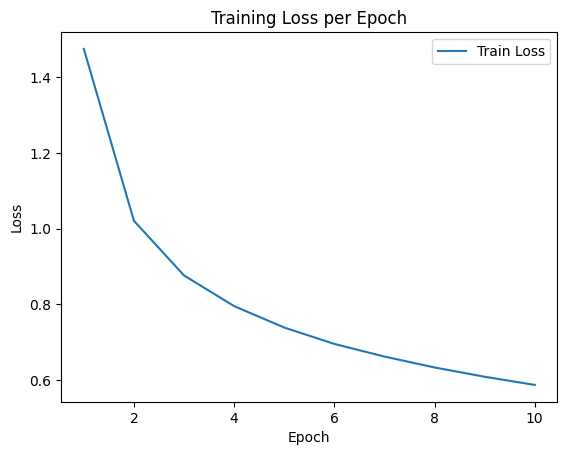

In [ ]:
# Plot training loss
epochs = list(range(1, len(loss_vals) + 1))

plt.plot(epochs, loss_vals, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

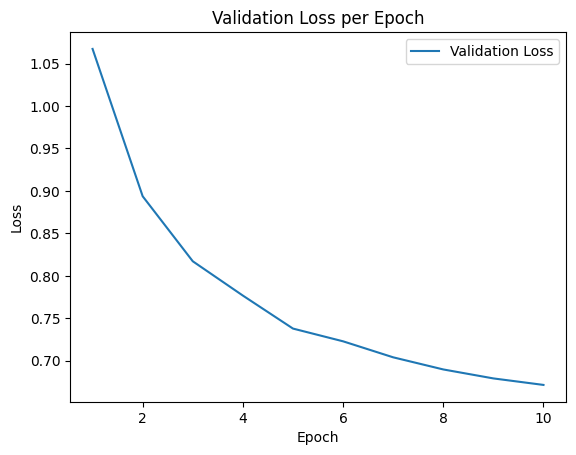

In [ ]:
# Plot validation loss
epochs = list(range(1, len(val_loss_vals) + 1))

plt.plot(epochs, val_loss_vals, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.show()

(12, 5)


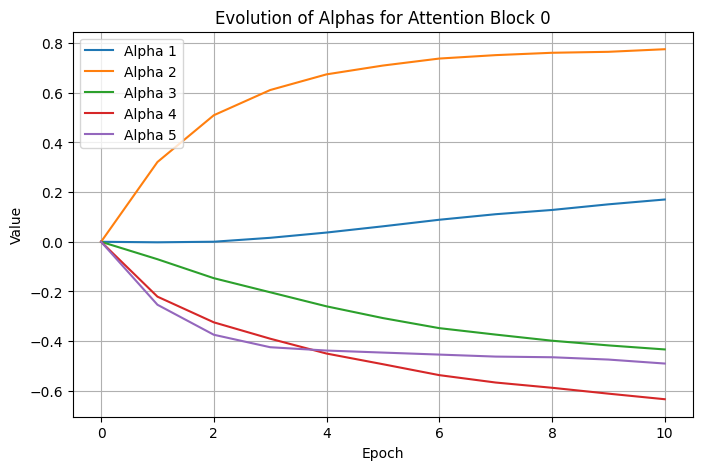

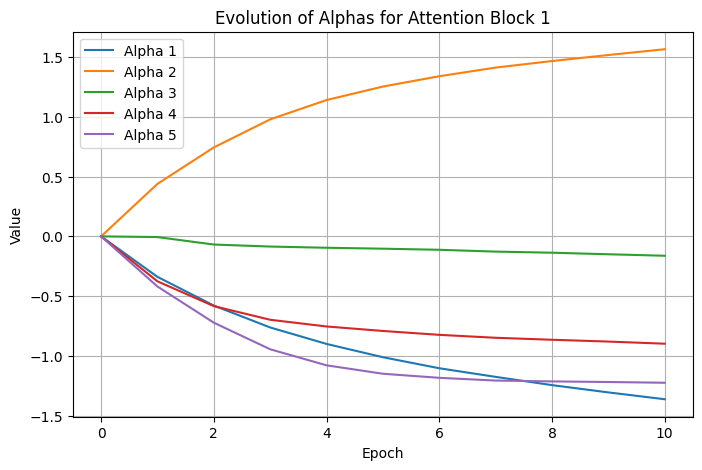

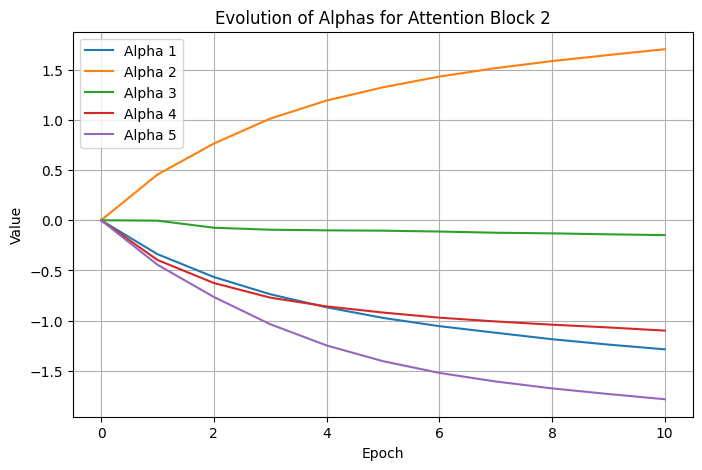

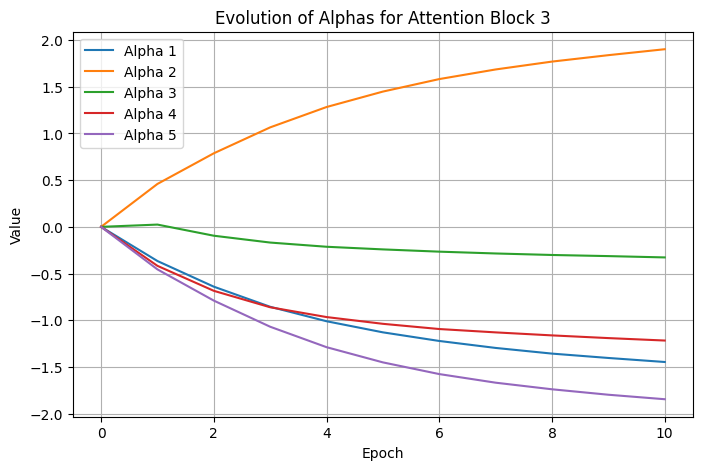

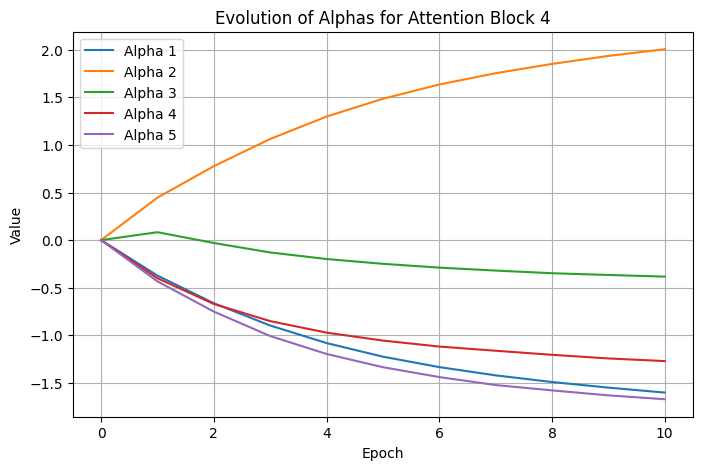

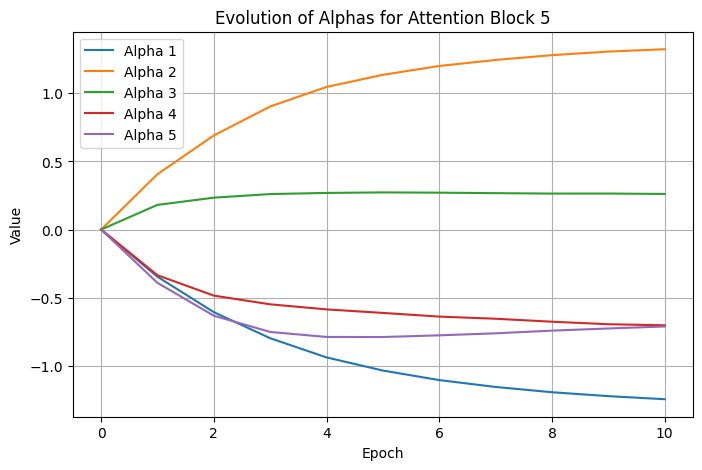

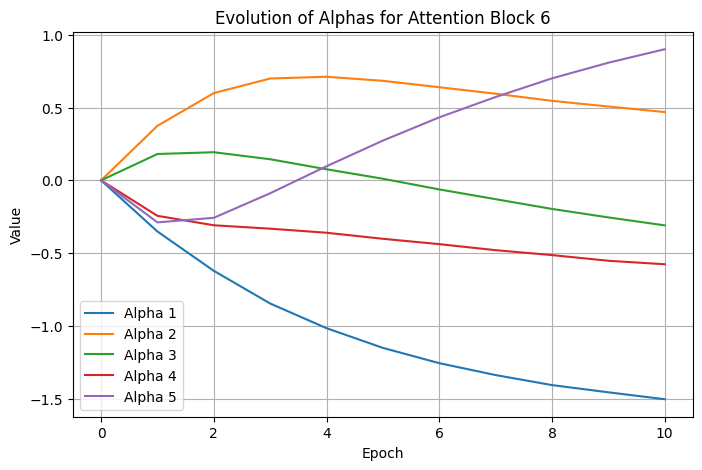

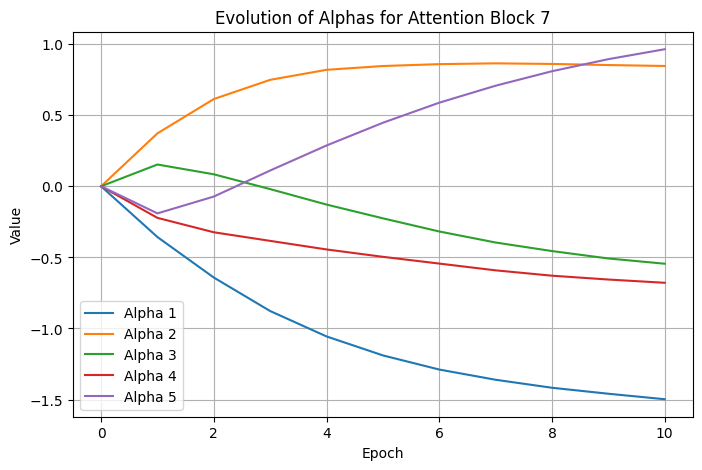

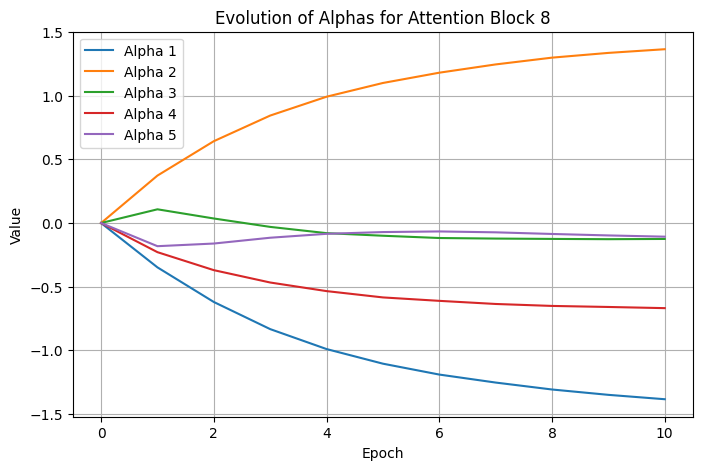

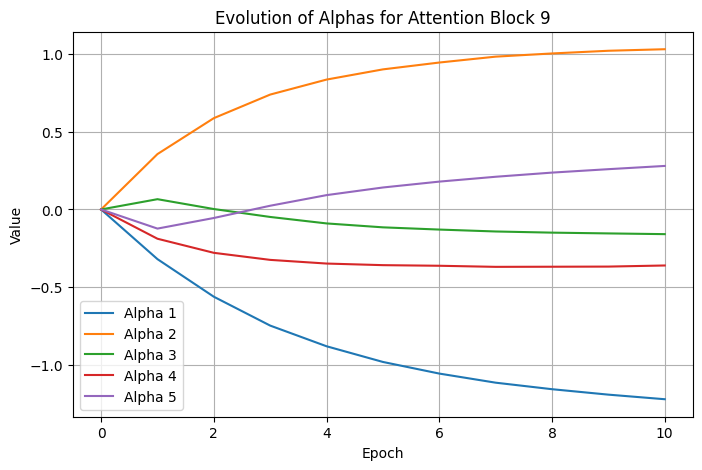

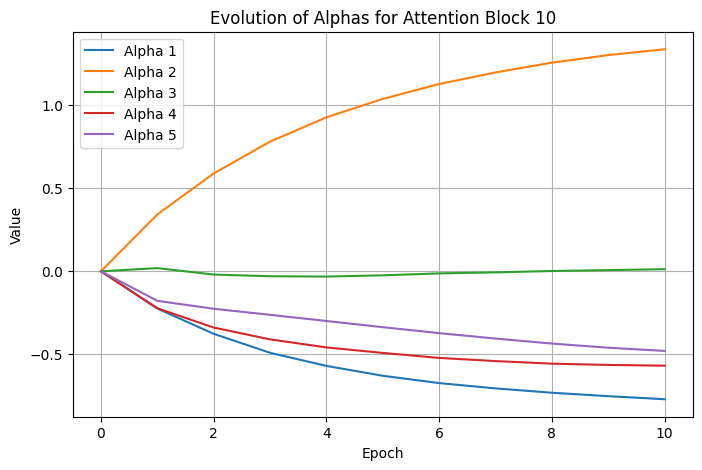

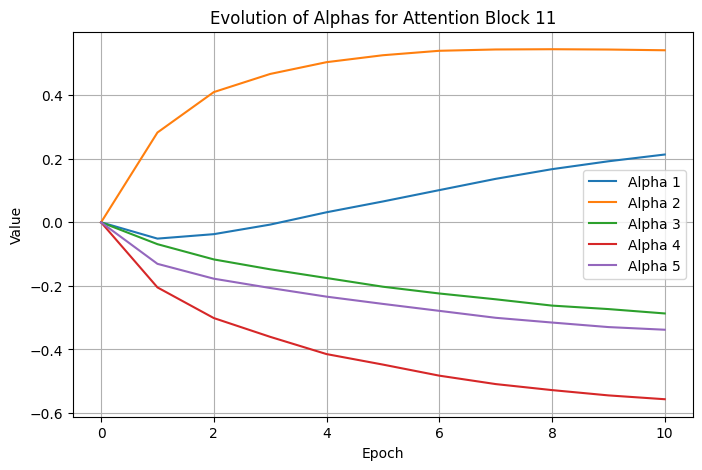

In [ ]:
# Plot alphas
print(all_alphas[0].shape)
for row_idx in range(all_alphas[0].shape[0]):
    plt.figure(figsize=(8, 5))

    time_series = np.array([matrix[row_idx] for matrix in all_alphas])

    for col_idx in range(all_alphas[0].shape[1]):
        plt.plot(time_series[:, col_idx], label=f'Alpha {col_idx + 1}')

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Evolution of Alphas for Attention Block {row_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ------------------------------
# Text Generation Comparison
# ------------------------------

def generate_text(model, prompt, max_length=50, temperature=0.7, top_k=50, tracker=None):
    """
    Generate text using the provided model and prompt.
    Note: We disable caching (use_cache=False) for our custom model.
    """
    if tracker is not None:
        tracker.start_tracking()

    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        sequences = model.generate(
            inputs.input_ids,
            max_length=max_length,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
            no_repeat_ngram_size=2,
            use_cache=False  # Disable caching for compatibility with custom attention.
        )

    seq_len = sequences.size(1)
    output = tokenizer.decode(sequences[0], skip_special_tokens=True)

    if tracker is not None:
        tracker.stop_tracking(is_training=False, max_token_length=seq_len)

    return output

In [ ]:
ref_tracker = UsageTracker()

In [ ]:
sample_prompts = [
    "Hello, my name is",
    "The meaning of life is",
    "In a shocking turn of events,",
    "The future of artificial intelligence"
]

longer_sample_prompts = [
    "As the sun set behind the towering mountains, the weary traveler finally caught sight of the distant village, its warm lights flickering like tiny stars",
    "In the year 2157, humanity had finally perfected interstellar travel. The first colony ship, brimming with hope and thousands of eager settlers",
    "The scientist stared at the glowing vial on the laboratory table, her fingers trembling with anticipation. After years of relentless experimentation",
    "The detective pushed open the heavy oak door, stepping into a room thick with the scent of old books and something more sinister—fear"
]

for prompt in sample_prompts + longer_sample_prompts:
    print()
    for i in range(30 if prompt in sample_prompts else 50, MAX_SEQ_LENGTH, 10):
        ref_text = generate_text(reference_model, prompt, max_length=i, tracker=ref_tracker)
        custom_text = generate_text(custom_model, prompt, max_length=i, tracker=tracker)
        print(f"Prompt:    {prompt}")
        print(f"Reference: {ref_text}")
        print(f"Custom:    {custom_text}")
        print("-" * 80)

    ref_text = generate_text(reference_model, prompt, max_length=MAX_SEQ_LENGTH, tracker=ref_tracker)
    custom_text = generate_text(custom_model, prompt, max_length=MAX_SEQ_LENGTH, tracker=tracker)
    print(f"Prompt:    {prompt}")
    print(f"Reference: {ref_text}")
    print(f"Custom:    {custom_text}")
    print("-" * 80)


Prompt:    Hello, my name is
Reference: Hello, my name is Jeeves.
A short time ago I had a personal friend who was very interested in learning about the history of our
Custom:    Hello, my name is David. And I'm not a real fan of them , and there are some people who want to try it out."

--------------------------------------------------------------------------------
Prompt:    Hello, my name is
Reference: Hello, my name is Mark Stokes.
You may know me from the time I was a teenager and as such has been one of your most loved writers since you came over here in 1981!
Custom:    Hello, my name is Yuliesh," says he's in love with her. He then asks him to kill the girl or let them die by stealing a scroll of magic from another world .
--------------------------------------------------------------------------------
Prompt:    Hello, my name is
Reference: Hello, my name is Thomas. I am at home in the hospital with an infection that's been going on for over twenty-five minutes now and it ju

As the alphas approach -infinity, this means the masks are less and less important, and as they approach +infinity, they are more and more important. (The coefficients of the candidate masks are actually the sigmoid of the alphas.)

Custom Model Plots


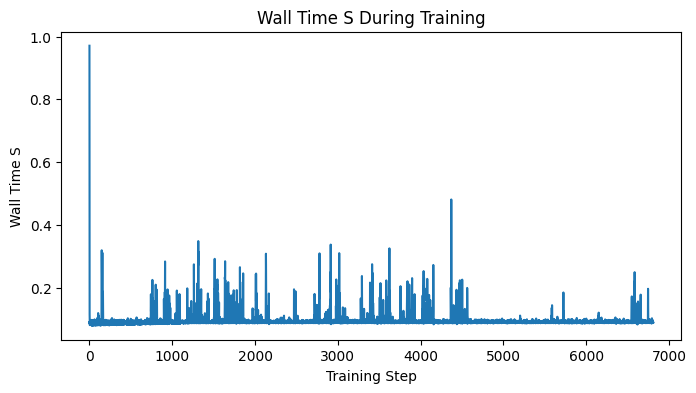

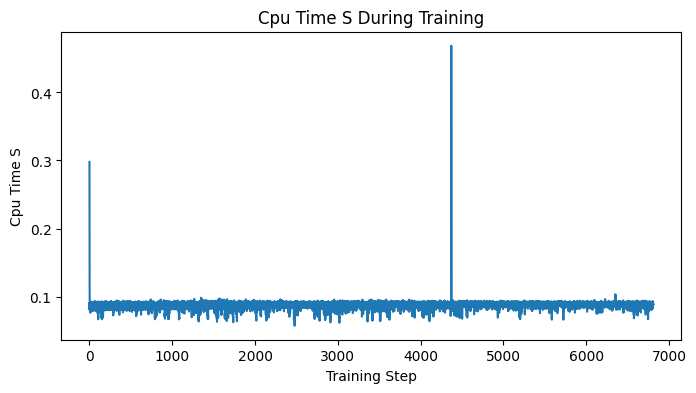

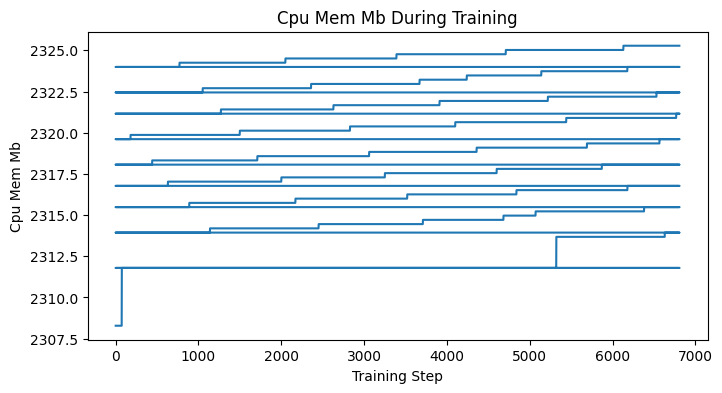

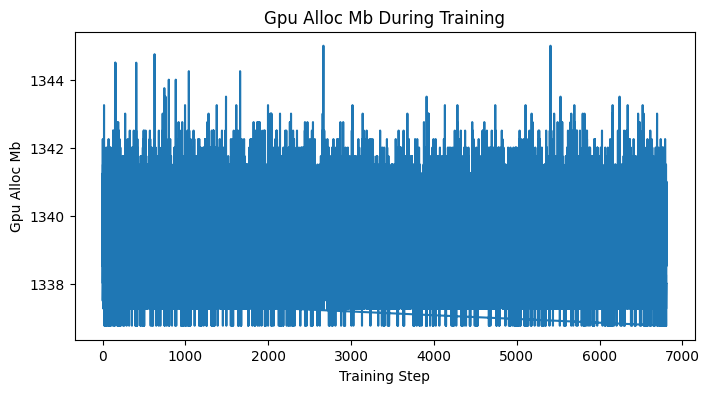

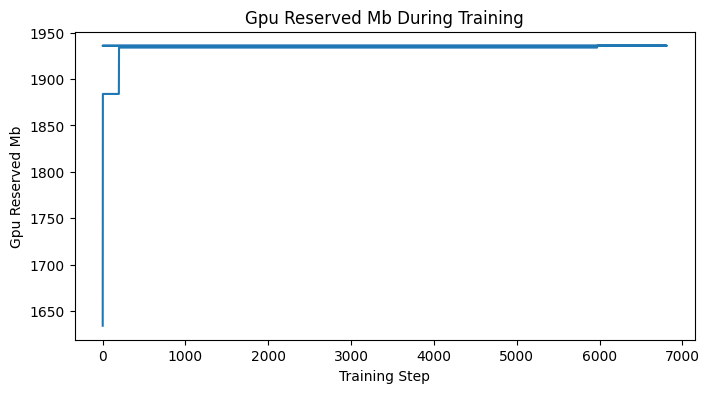

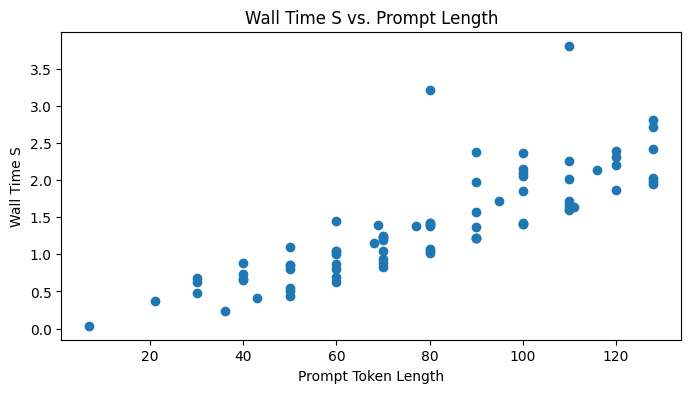

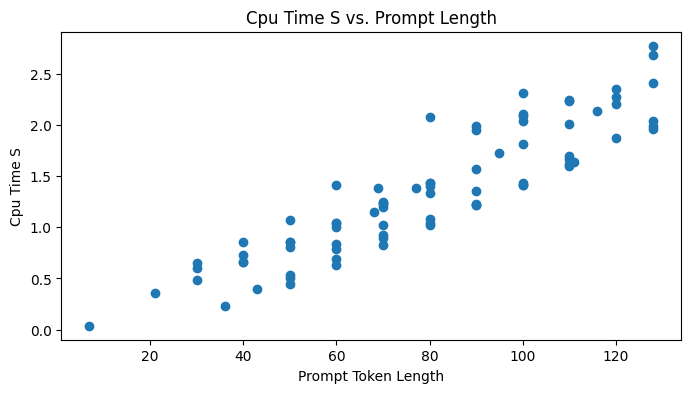

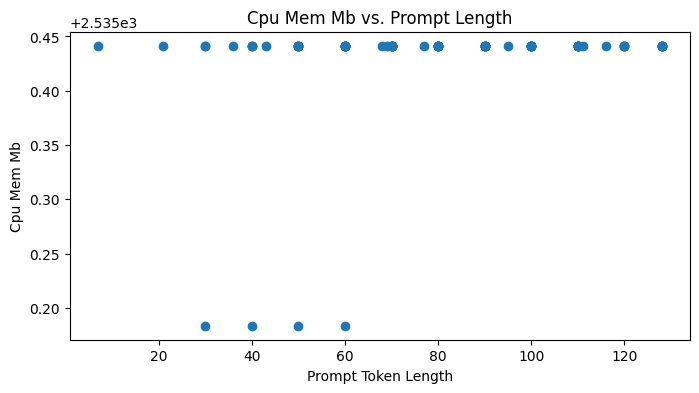

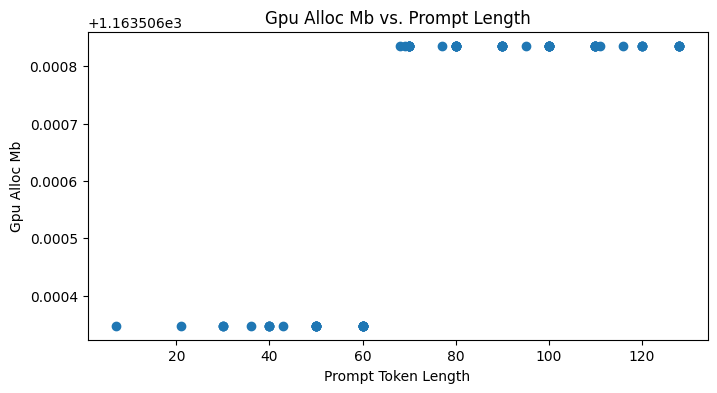

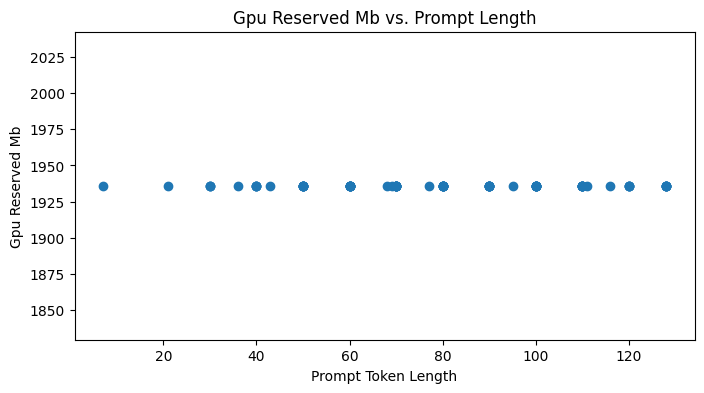

Reference Model Plots


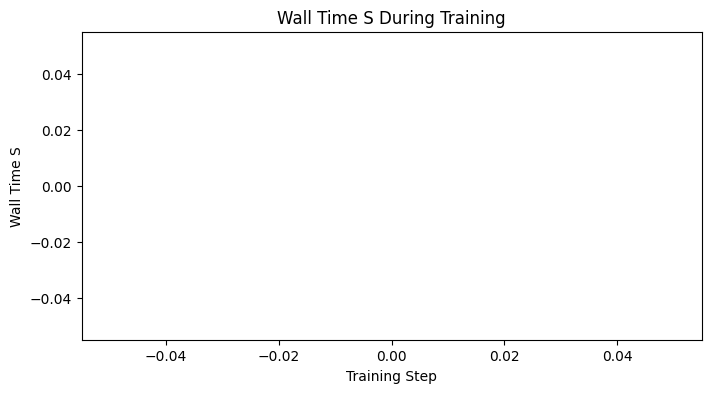

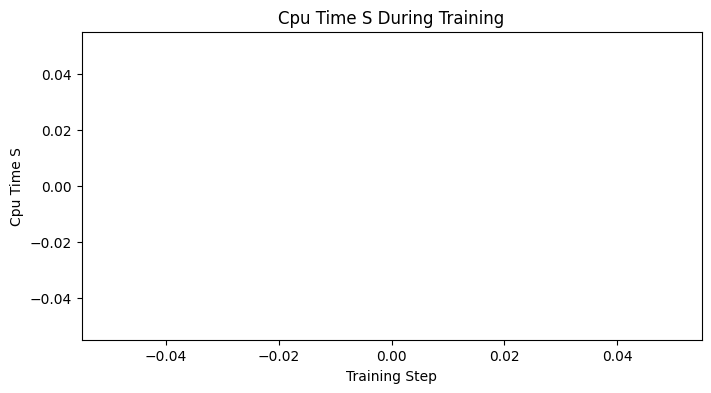

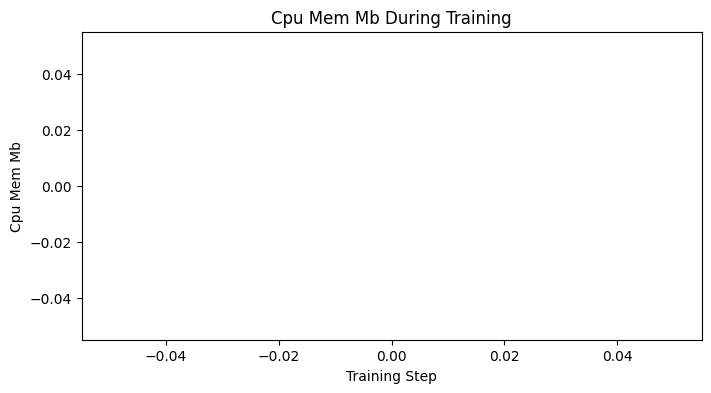

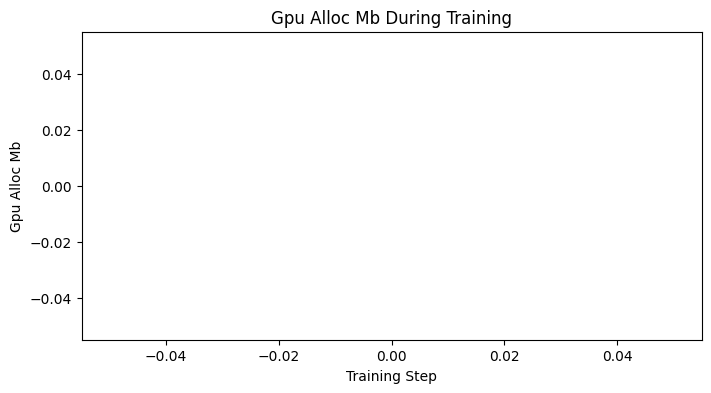

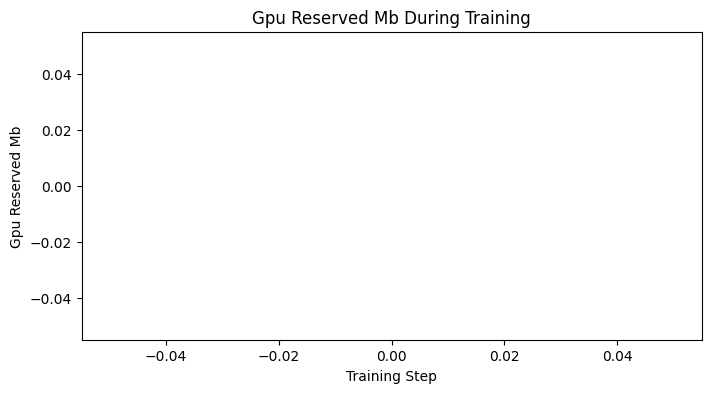

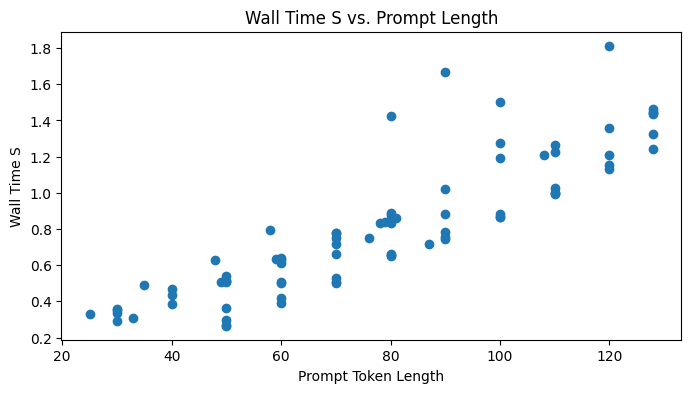

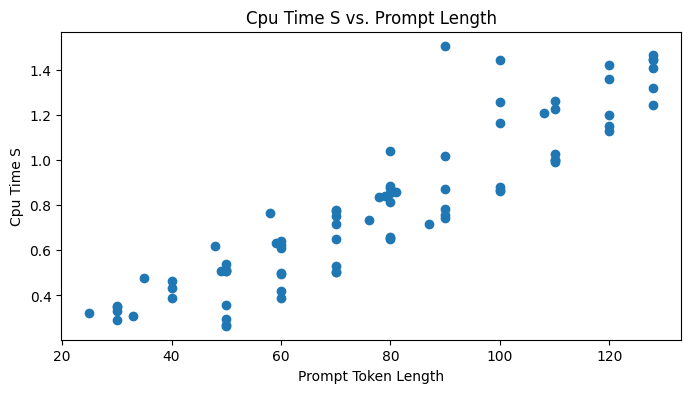

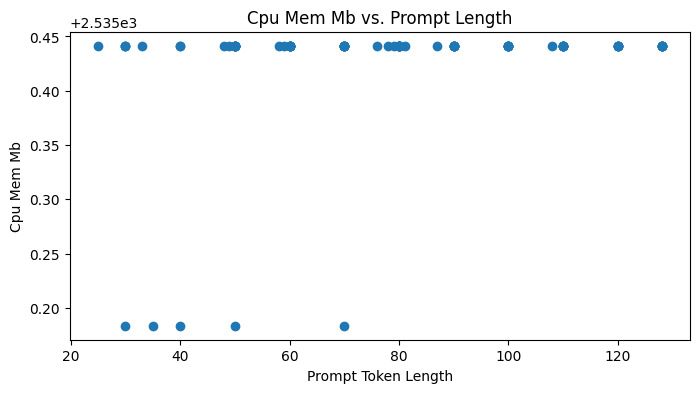

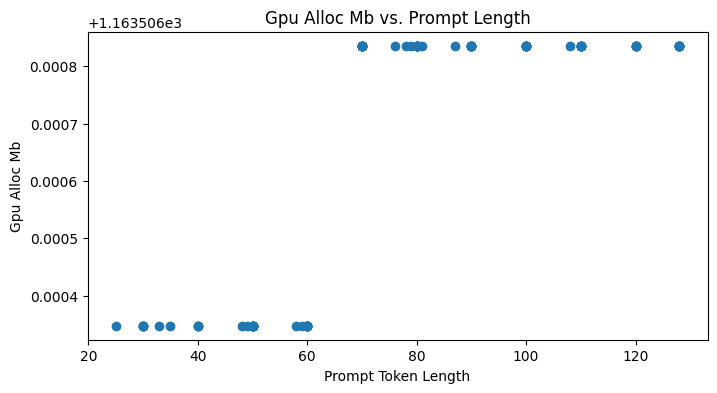

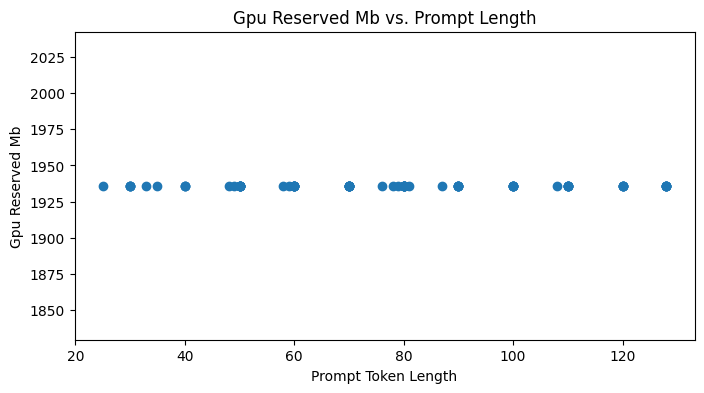

In [ ]:
# Plot usage
print("Custom Model Plots")
tracker.plot()
print("Reference Model Plots")
ref_tracker.plot()

In [ ]:
checkpoint = {
    'train_stats': tracker.train_stats,
    'infer_stats': tracker.infer_stats
}
torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'tracker_epoch_{epoch+1}.pth'))
print(f"Saved tracker for epoch {epoch+1}")

Saved tracker for epoch 10


In [ ]:
# Recovering alphas from disconnected runtime

import re
import numpy as np

with open("alphas.txt", "r") as f:
    text = f.read()

# Use a regex to find blocks that look like "[[ ... ]]".
# This assumes that each alpha block starts with '[[' and ends with ']]'.
blocks = re.findall(r'\[\[.*?\]\]', text, re.DOTALL)

all_alphas = []
for block in blocks:
    s_clean = block.replace('[', '').replace(']', '')

    try:
        numbers = [float(x) for x in s_clean.split()]
    except ValueError:
        continue

    R, C = 12, 5
    arr = np.array(numbers).reshape((R, C))
    all_alphas.append(arr)

print("Loaded alphas. The shape of the first alpha block is:", all_alphas[0].shape)
print(len(all_alphas))
print(all_alphas[-1])

Loaded alphas. The shape of the first alpha block is: (12, 5)
91
[[ 0.11276772  0.27678272 -0.13019454 -0.23810028 -0.22698945]
 [-0.60705     1.0572218  -0.0509609  -0.59397674 -0.8075716 ]
 [-0.6781548   1.206977   -0.2046482  -0.79239595 -0.940304  ]
 [-0.8323629   1.19656     0.13628529 -0.6395719  -0.92865163]
 [-0.8471574   1.1007881   0.16473274 -0.5321512  -0.7213727 ]
 [-0.72148716  0.8785625   0.19719124 -0.33714035 -0.5135435 ]
 [-0.7170839   0.6997543   0.14107034 -0.17646083 -0.23785852]
 [-0.84704727  0.78270495  0.18634206 -0.13293432 -0.23104385]
 [-0.79508895  0.77741694  0.16619934 -0.12849015 -0.15789966]
 [-0.7194569   0.81697035  0.12255336 -0.23584169 -0.23094893]
 [-0.35881883  0.5821953   0.06986348 -0.26985022 -0.31594193]
 [-0.10013125  0.4538732  -0.03658427 -0.31428763 -0.3730911 ]]


In [ ]:
import torch
import numpy as np

final_alphas_np = all_alphas[-1]

final_alphas_tensor = torch.tensor(final_alphas_np, dtype=torch.float32)

# Iterate through custom_model to set the alpha parameters
module_index = 0
for module in custom_model.modules():
    if isinstance(module, CustomLearnableAttention):
        module.alpha.data.copy_(final_alphas_tensor[module_index])
        module_index += 1

print("Custom model alphas updated.")

Custom model alphas updated.
